## Submit code for kaggle
### contest link: https://www.kaggle.com/c/credit-default-prediction-ai-big-data/overview

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import RandomizedSearchCV, KFold
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import shap
from scipy.special import softmax
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline

In [172]:
import random

In [173]:
df = pd.read_csv('course_project_train.csv')

In [174]:
# Проверка на наличие константных фичей
colsToRemove = []
for col in df.select_dtypes(exclude='object').columns:
    if col != 'Id' and col != 'Credit Default':
        if df[col].std() == 0: 
            colsToRemove.append(col)
print(colsToRemove) # Константные фичи отсутствуют

[]


In [175]:
df.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Приведение типов<a class="anchor" id="cast"></a>

In [176]:
# df.dtypes

In [177]:
for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    df[colname] = df[colname].astype(str)

### Обработка пропусков<a class="anchor" id="cast"></a>

In [178]:
# Фичи с пропусками: Bankruptcies, Credit Score, Annual Income, Months since last delinquent

In [179]:
# df.fillna(df.mean(),inplace=True)
# df.fillna(df.median(),inplace=True)
# df.fillna(-10000, inplace=True) # + 0.02 score

In [180]:
# len(df) - df.count()

In [181]:
# Обзор количественных признаков
df.describe()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,3749.500000,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,2165.207842,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,0.000000,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1874.750000,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,3749.500000,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,5624.250000,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,7499.000000,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [182]:
# Обзор номинативных признаков
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses 

**Dummies**

In [183]:
def get_dummies(data):
    for cat_colname in data.select_dtypes(include='object').columns[:]:
        data = pd.concat([data, pd.get_dummies(data[cat_colname], prefix=cat_colname)], axis=1)
    return data
df = get_dummies(df)

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 51 columns):
Id                                7500 non-null int64
Home Ownership                    7500 non-null object
Annual Income                     5943 non-null float64
Years in current job              7500 non-null object
Tax Liens                         7500 non-null float64
Number of Open Accounts           7500 non-null float64
Years of Credit History           7500 non-null float64
Maximum Open Credit               7500 non-null float64
Number of Credit Problems         7500 non-null float64
Months since last delinquent      3419 non-null float64
Bankruptcies                      7486 non-null float64
Purpose                           7500 non-null object
Term                              7500 non-null object
Current Loan Amount               7500 non-null float64
Current Credit Balance            7500 non-null float64
Monthly Debt                      7500 non-null float64
Cre

In [185]:
def drop_sparse(df):
    flist = [x for x in df.columns if not x in ['Id','Credit Default']]
    for f in flist:
        if len(np.unique(df[f]))<2:
            print(f)
            df.drop(f, axis=1, inplace=True)
    return df
df = drop_sparse(df)

### Анализ признакового пространства<a class="anchor" id="features_analysis"></a>

**Матрица корреляций**

In [186]:
def prep_feats(df, opt=1):
    

    PREPROCESS_FEATURES = ['Id', 'Annual Income', 'Tax Liens', 'Number of Open Accounts',
           'Years of Credit History', 'Maximum Open Credit',
           'Number of Credit Problems', 'Months since last delinquent',
           'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
           'Monthly Debt', 'Credit Score', 'Credit Default',
           'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
           'Home Ownership_Own Home', 'Home Ownership_Rent',
           'Years in current job_1 year', 'Years in current job_10_more years',
           'Years in current job_2 years', 'Years in current job_3 years',
           'Years in current job_4 years', 'Years in current job_5 years',
           'Years in current job_6 years', 'Years in current job_7 years',
           'Years in current job_8 years', 'Years in current job_9 years',
           'Years in current job_less 1 year', 'Years in current job_nan',
           'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
           'Purpose_debt consolidation', 'Purpose_educational expenses',
           'Purpose_home improvements', 'Purpose_major purchase',
           'Purpose_medical bills', 'Purpose_moving', 'Purpose_other',
           'Purpose_small business', 'Purpose_take a trip', 'Purpose_vacation',
           'Purpose_wedding', 'Term_Long Term', 'Term_Short Term']

    FEATURES_TO_DROP = ['Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Purpose_renewable energy']
    FEATURES_TO_DROP_2 = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
    
    if opt==1:        
        df = df.drop(FEATURES_TO_DROP, axis=1)
        df.columns = PREPROCESS_FEATURES
        
    if opt==2:
        df = df.drop(FEATURES_TO_DROP_2, axis=1)
        PREPROCESS_FEATURES.remove('Credit Default')
        df.columns = PREPROCESS_FEATURES
        
    return df

In [187]:
import plotly.graph_objs as go

In [189]:
df = prep_feats(df, opt=1)

TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

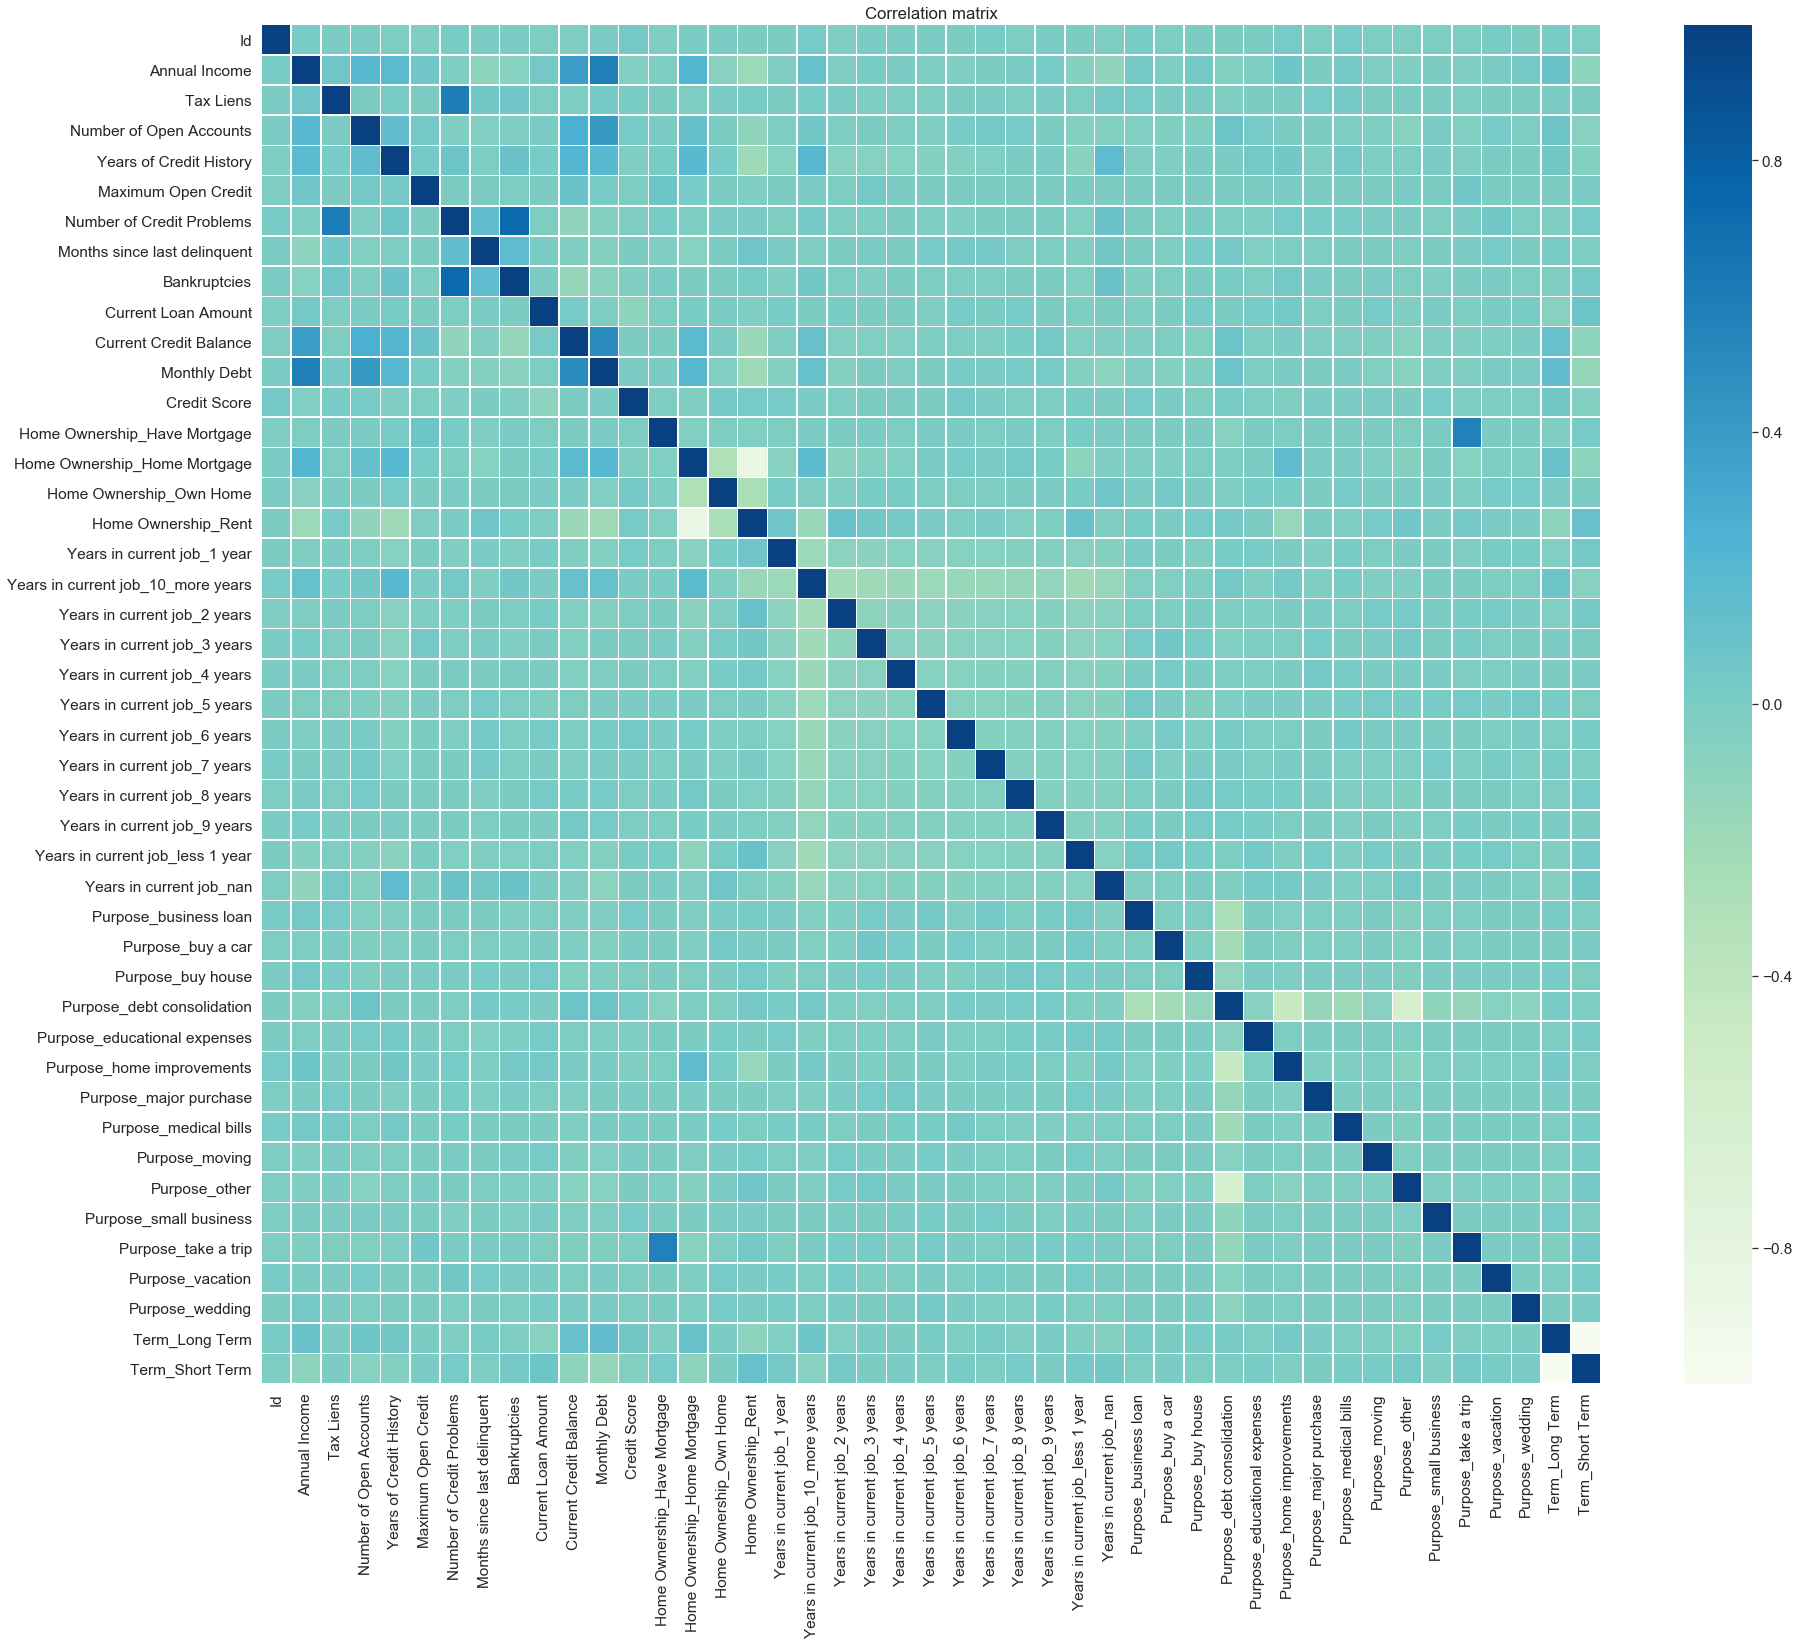

In [190]:
plt.figure(figsize = (30,25))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Корреляция с базовыми признаками**

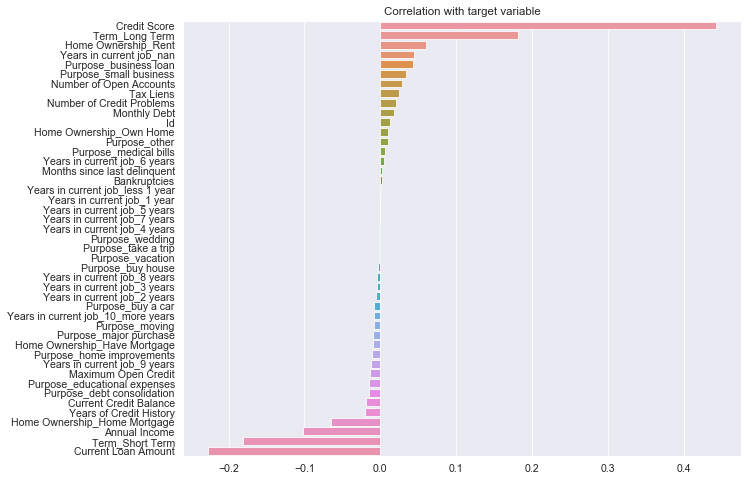

In [191]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.set_context("paper", font_scale=1.2)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [192]:
a = df.corr()
high_corr = a.loc[a['Credit Default']>abs(0.05),'Credit Default']
high_corr

Credit Score           0.442050
Credit Default         1.000000
Home Ownership_Rent    0.060114
Term_Long Term         0.181487
Name: Credit Default, dtype: float64

In [193]:
# df.loc[df['Credit Score']>np.percentile(df['Credit Score'],75),'Credit Score']=np.percentile(df['Credit Score'],75)
# df.loc[df['Credit Score']<np.percentile(df['Credit Score'],25),'Credit Score']=np.percentile(df['Credit Score'],25)

# df.loc[df['Home Ownership_Rent']>np.percentile(df['Home Ownership_Rent'],75),'Home Ownership_Rent']=np.percentile(df['Home Ownership_Rent'],75)
# df.loc[df['Home Ownership_Rent']<np.percentile(df['Home Ownership_Rent'],25),'Home Ownership_Rent']=np.percentile(df['Home Ownership_Rent'],25)

# df.loc[df['Current Loan Amount']>np.percentile(df['Current Loan Amount'],75),'Current Loan Amount']=np.percentile(df['Current Loan Amount'],75)
# df.loc[df['Current Loan Amount']<np.percentile(df['Current Loan Amount'],25),'Current Loan Amount']=np.percentile(df['Current Loan Amount'],25)

# df.loc[df['Term_Short Term']>np.percentile(df['Term_Short Term'],75),'Term_Short Term']=np.percentile(df['Term_Short Term'],75)
# df.loc[df['Term_Short Term']<np.percentile(df['Term_Short Term'],25),'Term_Short Term']=np.percentile(df['Term_Short Term'],25)

In [194]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

X = X.drop('Id', axis=1)
# Делим выборку на train и test, все метрики будем оценивать на тестовом датасете

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,  test_size=0.33, random_state=42)

In [195]:
# scaler=MinMaxScaler()
# X_train =  scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

Выбор наиболее подходящей модели:

In [208]:
models = []
models.append(RandomForestClassifier(n_estimators=165, max_depth=4, criterion='entropy'))
models.append(GradientBoostingClassifier(max_depth =4))
models.append(KNeighborsClassifier(n_neighbors=20))
models.append(GaussianNB())
models.append(LogisticRegression())
models.append(xgb.XGBClassifier(random_state=21))
models.append(lgbm.LGBMClassifier(random_state=21))
models.append(catb.CatBoostClassifier(silent=True, random_state=21))

C:\Users\Nickel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


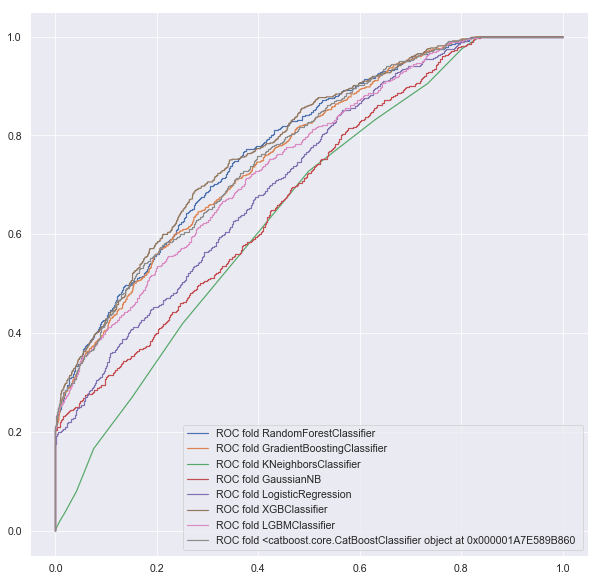

In [280]:
plt.figure(figsize=(10, 10)) 
for model in models:
    model.fit(X_train, y_train)
    # pred_scr = model.predict_proba(X_test)[:, 1]
    # fpr, tpr, thresholds = roc_curve(y_test, pred_scr)
    # roc_auc = ml_metrics.auc(TARtest, pred_scr)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=1)
    md = str(model)
    md = md[:md.find('(')]
    plt.plot(fpr, tpr, label='ROC fold %s ' % (md))
    # pl.plot(fpr, tpr, label='ROC fold %s (auc = %0.2f)' % (md, roc_auc))

# pl.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
# pl.xlim([0, 1])
# pl.ylim([0, 1])
# pl.xlabel('False Positive Rate')
# pl.ylabel('True Positive Rate')
# pl.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [204]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [223]:
for model in models:
    print(f'MODEL NAME: {"*"*40} {model.__class__.__name__} {"*"*40}')
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    report = get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    print(f'{report}')

MODEL NAME: **************************************** RandomForestClassifier ****************************************
TRAIN

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3609
           1       1.00      0.18      0.31      1416

   micro avg       0.77      0.77      0.77      5025
   macro avg       0.88      0.59      0.58      5025
weighted avg       0.83      0.77      0.71      5025

TEST

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1778
           1       1.00      0.20      0.34       697

   micro avg       0.78      0.78      0.78      2475
   macro avg       0.88      0.60      0.60      2475
weighted avg       0.83      0.78      0.72      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1778    0
1                555  142
None
MODEL NAME: **************************************** GradientBoostingClassifier *********

C:\Users\Nickel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


TRAIN

              precision    recall  f1-score   support

           0       0.75      0.99      0.85      3609
           1       0.89      0.14      0.24      1416

   micro avg       0.75      0.75      0.75      5025
   macro avg       0.82      0.57      0.55      5025
weighted avg       0.79      0.75      0.68      5025

TEST

              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1778
           1       0.90      0.16      0.27       697

   micro avg       0.76      0.76      0.76      2475
   macro avg       0.82      0.58      0.56      2475
weighted avg       0.79      0.76      0.69      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1765   13
1                586  111
None
MODEL NAME: **************************************** XGBClassifier ****************************************
TRAIN

              precision    recall  f1-score   support

           0       0.78      0.98   

### Выбор наилучшей модели
**Подбор гиперпараметров**

In [206]:
params = {'n_estimators':[50, 100, 200], 
          'max_depth':[3, 5, 7, 10],
          'learning_rate':[ 0.01, 0.05, 0.07, 0.1]}

In [207]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [209]:
rs = RandomizedSearchCV(catb.CatBoostClassifier(), params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

0:	learn: 0.6500057	total: 4.04ms	remaining: 804ms
1:	learn: 0.6254772	total: 6.89ms	remaining: 683ms
2:	learn: 0.6042012	total: 10.4ms	remaining: 685ms
3:	learn: 0.5855678	total: 13.9ms	remaining: 683ms
4:	learn: 0.5708709	total: 17.3ms	remaining: 675ms
5:	learn: 0.5592573	total: 20.3ms	remaining: 657ms
6:	learn: 0.5425136	total: 23.5ms	remaining: 648ms
7:	learn: 0.5342283	total: 27.1ms	remaining: 650ms
8:	learn: 0.5261582	total: 31.8ms	remaining: 675ms
9:	learn: 0.5207751	total: 35ms	remaining: 665ms
10:	learn: 0.5159596	total: 38ms	remaining: 654ms
11:	learn: 0.5087703	total: 40.8ms	remaining: 639ms
12:	learn: 0.5052329	total: 43.9ms	remaining: 631ms
13:	learn: 0.5019686	total: 48.3ms	remaining: 641ms
14:	learn: 0.4960399	total: 52.7ms	remaining: 650ms
15:	learn: 0.4936530	total: 57.5ms	remaining: 661ms
16:	learn: 0.4912192	total: 61.4ms	remaining: 661ms
17:	learn: 0.4894854	total: 64.9ms	remaining: 657ms
18:	learn: 0.4876901	total: 69ms	remaining: 657ms
19:	learn: 0.4859473	total: 

160:	learn: 0.4029034	total: 561ms	remaining: 136ms
161:	learn: 0.4024493	total: 564ms	remaining: 132ms
162:	learn: 0.4019010	total: 567ms	remaining: 129ms
163:	learn: 0.4013492	total: 571ms	remaining: 125ms
164:	learn: 0.4007829	total: 575ms	remaining: 122ms
165:	learn: 0.4004769	total: 579ms	remaining: 119ms
166:	learn: 0.3998981	total: 582ms	remaining: 115ms
167:	learn: 0.3993582	total: 586ms	remaining: 112ms
168:	learn: 0.3988529	total: 590ms	remaining: 108ms
169:	learn: 0.3985654	total: 594ms	remaining: 105ms
170:	learn: 0.3981290	total: 597ms	remaining: 101ms
171:	learn: 0.3976370	total: 600ms	remaining: 97.7ms
172:	learn: 0.3970771	total: 604ms	remaining: 94.2ms
173:	learn: 0.3967480	total: 608ms	remaining: 90.8ms
174:	learn: 0.3962360	total: 612ms	remaining: 87.4ms
175:	learn: 0.3957307	total: 615ms	remaining: 83.9ms
176:	learn: 0.3951193	total: 619ms	remaining: 80.4ms
177:	learn: 0.3947578	total: 622ms	remaining: 76.9ms
178:	learn: 0.3942104	total: 626ms	remaining: 73.5ms
179:

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
          error_score='raise-deprecating',
          estimator=<catboost.core.CatBoostClassifier object at 0x0000026973F18BA8>,
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 10], 'learning_rate': [0.01, 0.05, 0.07, 0.1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [210]:
rs.best_params_

{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.07}

In [211]:
rs.best_score_ # last res: 0.45413190493808214, 0.4280952513084807, 0.45554294668624684

0.43542413497435983

### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [212]:
# best tuned score - 0.55

In [213]:
final_model = catb.CatBoostClassifier(n_estimators=250, max_depth=5, learning_rate=0.05,
                                      silent=True, random_state=21,
                                      l2_leaf_reg=0,
                                      class_weights=[1, 3.5],
                                      nan_mode='Max')

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.71      0.82      3609
           1       0.56      0.92      0.69      1416

   micro avg       0.77      0.77      0.77      5025
   macro avg       0.76      0.82      0.76      5025
weighted avg       0.85      0.77      0.78      5025

TEST

              precision    recall  f1-score   support

           0       0.86      0.63      0.72      1778
           1       0.44      0.74      0.55       697

   micro avg       0.66      0.66      0.66      2475
   macro avg       0.65      0.68      0.64      2475
weighted avg       0.74      0.66      0.67      2475

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1113  665
1                183  514


In [214]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

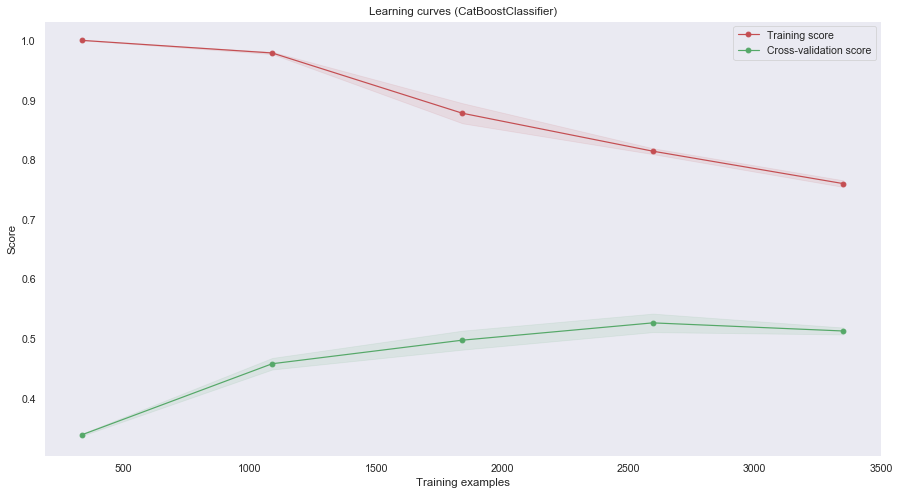

In [227]:
show_learning_curve_plot(final_model, X_train, y_train)

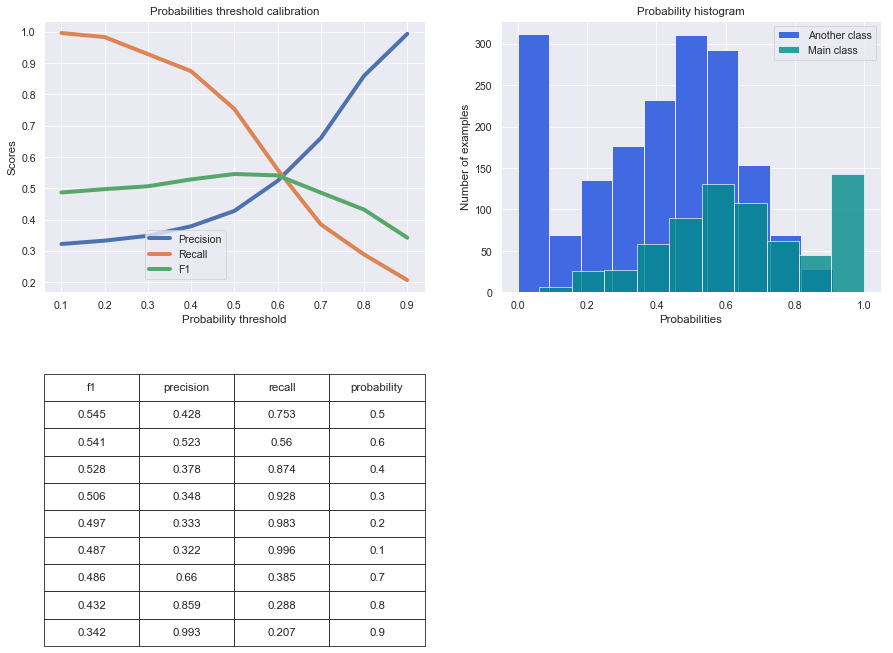

In [228]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

Confusion matrix, without normalization
[[1089  689]
 [ 189  508]]


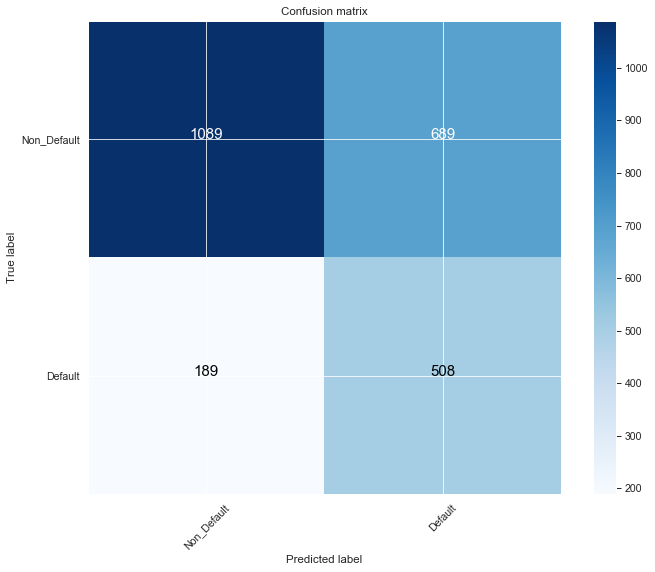

In [294]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, final_model.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non_Default', 'Default'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

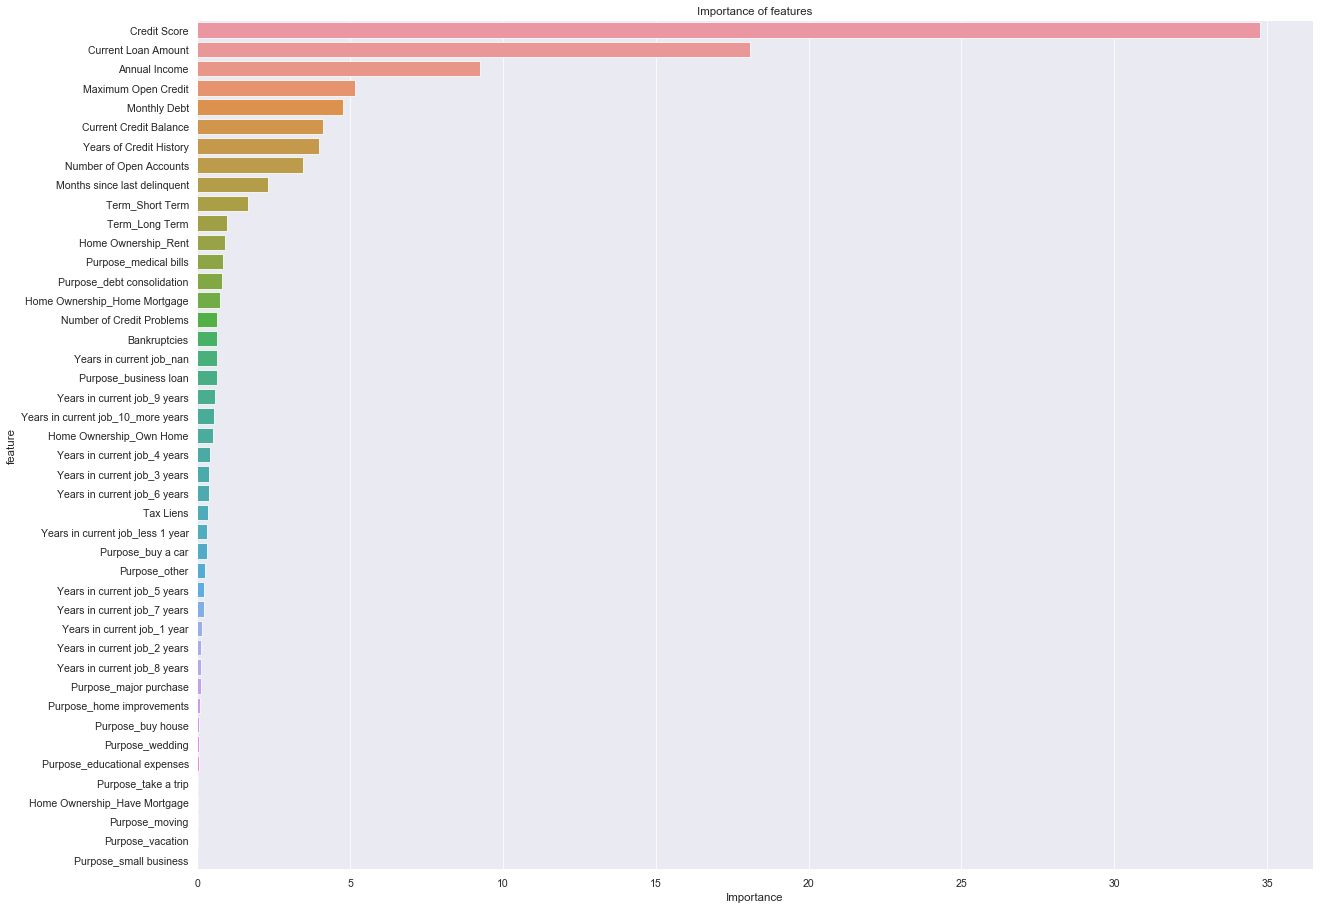

In [297]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

### Оценка важностей фич по выбранной модели

C:\Users\Nickel\Anaconda3\lib\site-packages\shap\plots\summary.py:56: UserWarning: auto_size_plot=False is depricated and is now ignored! Use plot_size=None instead.
  warnings.warn("auto_size_plot=False is depricated and is now ignored! Use plot_size=None instead.")


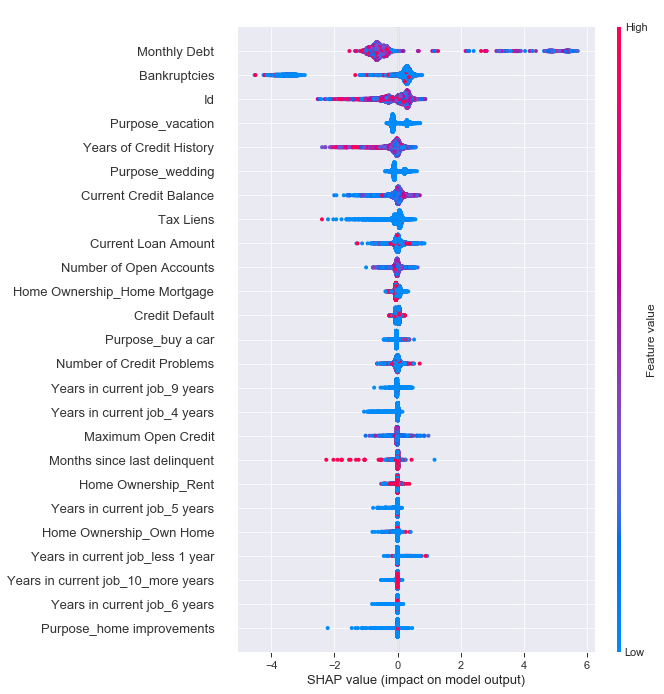

In [229]:
shap_test = shap.TreeExplainer(final_model).shap_values(df)
shap.summary_plot(shap_test, df,
                      max_display=25, auto_size_plot=True)

### Отработка модели на тестовых данных

In [232]:
test_df = pd.read_csv('course_project_test.csv')

In [233]:
for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    test_df[colname] = test_df[colname].astype(str)
    
# test_df.fillna(df.mean(),inplace=True)
test_df.fillna(-10000, inplace=True)
test_df = get_dummies(test_df)
test_df = prep_feats(test_df, opt=2)

In [234]:
test_df['Credit Default']=final_model.predict(test_df)

In [235]:
test_df['Credit Default'] = test_df['Credit Default'].astype('uint8')

In [236]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 46 columns):
Id                                    2500 non-null int64
Annual Income                         2500 non-null float64
Tax Liens                             2500 non-null float64
Number of Open Accounts               2500 non-null float64
Years of Credit History               2500 non-null float64
Maximum Open Credit                   2500 non-null float64
Number of Credit Problems             2500 non-null float64
Months since last delinquent          2500 non-null float64
Bankruptcies                          2500 non-null float64
Current Loan Amount                   2500 non-null float64
Current Credit Balance                2500 non-null float64
Monthly Debt                          2500 non-null float64
Credit Score                          2500 non-null float64
Home Ownership_Have Mortgage          2500 non-null uint8
Home Ownership_Home Mortgage          2500 non-null uint8

In [237]:
test_df.loc[:,['Id','Credit Default']].to_csv('Try_6.csv',index=None)